In [1]:
import sqlite3
import csv
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
con = sqlite3.connect('works_db')

In [3]:
cur = con.cursor()

In [ ]:
cur.execute("""CREATE TABLE works(
    "ID" INTEGER PRIMARY KEY AUTOINCREMENT,
    "salary" INTEGER,
    "educationType" TEXT,
    "jobTitle" TEXT,
    "qualification" TEXT,
    "gender" TEXT,
    "dateModify" TEXT,
    "skills" TEXT,
    "otherInfo" TEXT
);""")

In [ ]:
# https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python
to_db = None
with open('works.csv', newline='', encoding='utf-8') as csv_source:
    reader = csv.DictReader(csv_source)
    to_db = [(r['salary'], r['educationType'], r['jobTitle'], r['qualification'], r['gender'], r['dateModify'], r['skills'], r['otherInfo']) 
             for r in reader]

In [ ]:
stmt = '''INSERT INTO works (salary, educationType, jobTitle, qualification, gender, dateModify, skills, otherInfo) 
        VALUES (?, ?, ?, ?, ?, ?, ?, ?);'''
cur.executemany(stmt, to_db)

In [14]:
con.commit()

In [17]:
# объем файла до добавления индекса
print("Обьем в байтах без индекса: ", os.path.getsize('works_db'))# 2191360 байт

2191360

In [18]:
cur.execute("CREATE INDEX salary_idx ON works (salary);")
# объем файла после добавления индекса
print("Обьем в байтах с индексом: ", os.path.getsize('works_db'))# 2310144 байт

2310144


In [23]:
# количество записей
total_count = 0
for res in cur.execute("SELECT COUNT(*) FROM works;"):
    total_count = res[0]
print("Количество строк: ", total_count) # 11063

Количество строк:  11063


In [25]:
# количество женщин и мужчин
women_count = 0
for res in cur.execute("SELECT COUNT(gender) FROM works WHERE gender='Женский';"):
    women_count = res[0]

men_count = 0
for res in cur.execute("SELECT COUNT(gender) FROM works WHERE gender='Мужской';"):
    men_count = res[0]

print("Количество женщин: ", women_count) # 5996
print("Количество мужчин: ", men_count) # 4588
print("Пол не указан: ", total_count-women_count-men_count) # 479

Количество женщин:  5996
Количество мужчин:  4588
Пол не указан:  479


In [26]:
has_skills  = list(cur.execute("SELECT skills FROM works WHERE skills IS NOT NULL AND skills!='';"))
for res in has_skills[:3]:
    print(res[0])

<p>Уверенно владею компьютером, оргтехникой, работаю в программах:&nbsp; Excel, Word,&nbsp; хорошо знаю русский язык.&nbsp;</p>
<p>владение компьютером и оргтехникой, ведение отчетности, ведение базы данных, умение договариваться с клиентами,</p>
<p>Обладаю аналитическим складом ума, быстро обучаема, работоспособна, исполнительна, организованна, стрессоустойчива. Обладаю навыком работы с большим объемом информации.</p>


In [30]:
# зарплата специалистов, владеющих python
python_salary = []
for val in cur.execute("SELECT salary FROM works WHERE skills LIKE '%python%';"):
    python_salary.append(val[0])
print(python_salary) # 30000, 65000, 18000

[30000, 65000, 18000]


In [25]:
# перцентили по зарплате женщин и мужчин
women_salary = np.array([s[0] for s in cur.execute("SELECT salary FROM works WHERE gender='Женский';")])
men_salary = np.array([s[0] for s in cur.execute("SELECT salary FROM works WHERE gender='Мужской';")])
percentiles = range(10, 91, 10)
women_percentiles = np.percentile(women_salary, percentiles, interpolation='lower')
men_percentiles = np.percentile(men_salary, percentiles, interpolation='lower')
for idx, v in enumerate(percentiles):
    print(f"{percentiles[idx]}% женщин получают до {women_percentiles[idx]}")
    print(f"{percentiles[idx]}% мужчин получают до {men_percentiles[idx]}")
# Женщины: [20000 25000 35000] для перцентилей [30, 50, 80]
# Мужчины: [25000 30000 50000] для перцентилей [30, 50, 80]

10% женщин получают до 15000
10% мужчин получают до 15000
20% женщин получают до 18000
20% мужчин получают до 20000
30% женщин получают до 20000
30% мужчин получают до 25000
40% женщин получают до 20000
40% мужчин получают до 30000
50% женщин получают до 25000
50% мужчин получают до 30000
60% женщин получают до 28000
60% мужчин получают до 35000
70% женщин получают до 30000
70% мужчин получают до 40000
80% женщин получают до 35000
80% мужчин получают до 50000
90% женщин получают до 45000
90% мужчин получают до 60000


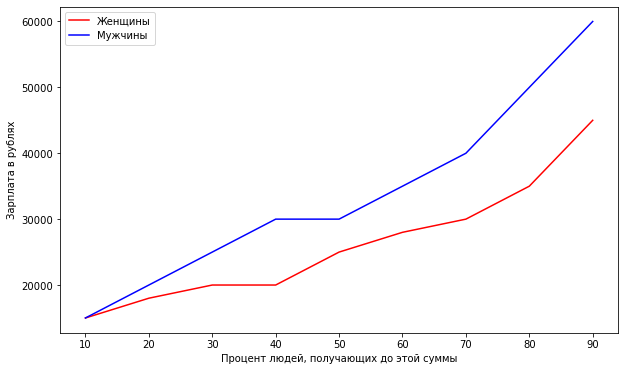

In [29]:
figure(figsize=(10, 6))
plt.ylabel("Зарплата в рублях")
plt.xlabel("Процент людей, получающих до этой суммы")
plt.plot(percentiles, women_percentiles, 'r')
plt.plot(percentiles, men_percentiles, 'b')
plt.legend(["Женщины", "Мужчины"])
plt.show()

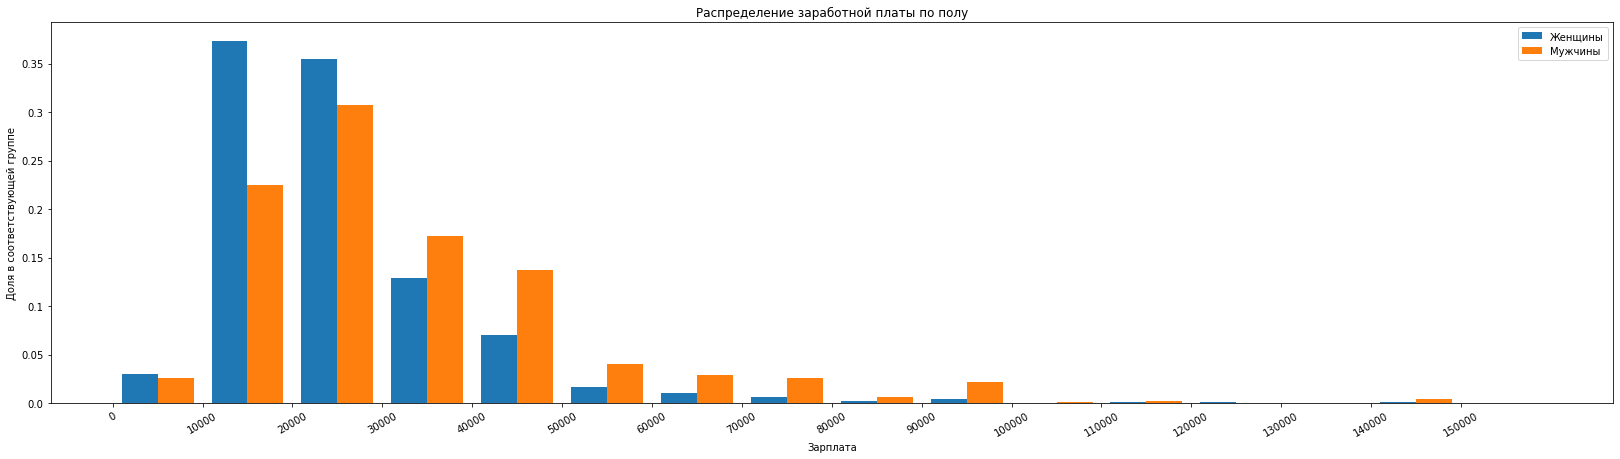

In [37]:
# распределения зарплат до 160 тыс. руб.
# количество людей, зарабатывающих больше, единицы 
# поэтому они не включены в расчет
sal_step = 10000
figure(figsize=(28,7))
sal_upper_boundary = 160000
women_data = women_salary[women_salary<=sal_upper_boundary]
men_data = men_salary[men_salary<=sal_upper_boundary]
bins = int(sal_upper_boundary/sal_step)
xs = range(0, sal_upper_boundary, sal_step)
y_loc = [i*1e-6 for i in range(0, 36, 5)]
ys = [round(i*sal_step, 2) for i in y_loc]
plt.xticks(ticks=xs, labels=xs, rotation=30)
plt.yticks(ticks=y_loc, labels=ys)
plt.hist([women_data, men_data], bins, label=['Женщины','Мужчины'], density=True)
plt.legend(loc='upper right')
plt.title("Распределение заработной платы по полу")
plt.ylabel("Доля в соответствующей группе")
plt.xlabel("Зарплата")
plt.show()

In [38]:
for r in cur.execute("SELECT DISTINCT educationType FROM works;"):
    print(r)

('Среднее',)
('Среднее профессиональное',)
('',)
('Высшее',)
('Незаконченное высшее',)


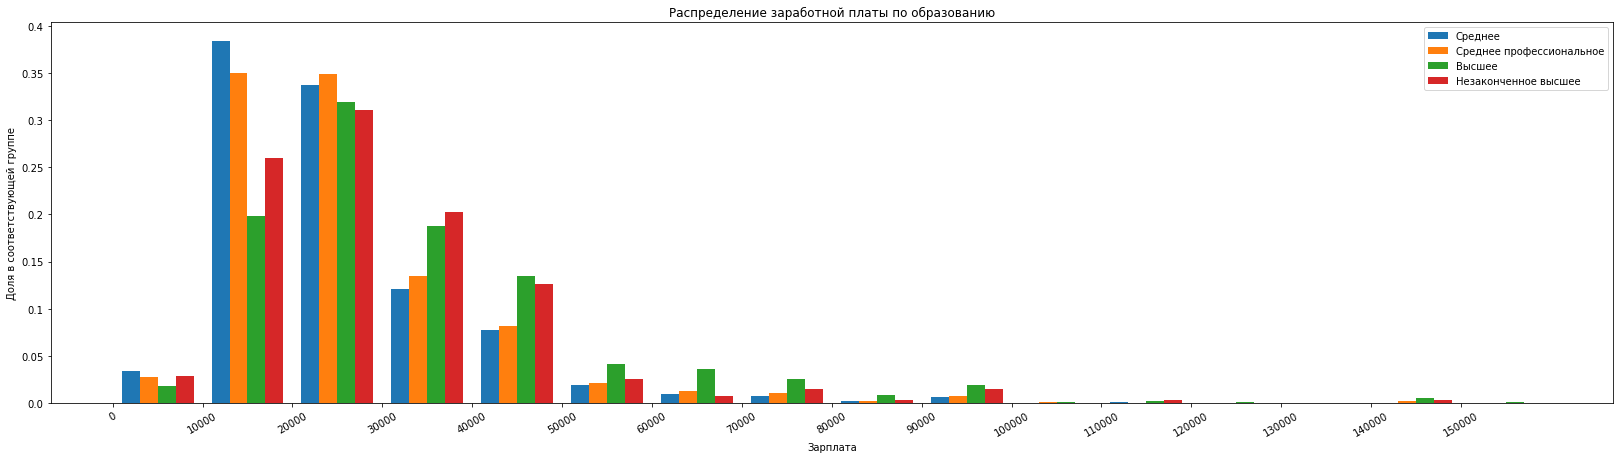

In [43]:
stmt = "SELECT salary FROM works WHERE salary <= "+ str(sal_upper_boundary) +" AND educationType = "
school = np.array([i[0] for i in cur.execute(stmt + "'Среднее';")])
coll = np.array([i[0] for i in cur.execute(stmt + "'Среднее профессиональное';")])
bach = np.array([i[0] for i in cur.execute(stmt + "'Высшее';")])
dropout = np.array([i[0] for i in cur.execute(stmt + "'Незаконченное высшее';")])

y_loc = [i*1e-6 for i in range(0, 41, 5)]
ys = [round(i*sal_step, 2) for i in y_loc]
figure(figsize=(28,7))
plt.xticks(ticks=xs, labels=xs, rotation=30)
plt.yticks(ticks=y_loc, labels=ys)
plt.hist([school, coll, bach, dropout], bins, label=['Среднее','Среднее профессиональное','Высшее','Незаконченное высшее'], density=True)
plt.legend(loc='upper right')
plt.title("Распределение заработной платы по образованию")
plt.ylabel("Доля в соответствующей группе")
plt.xlabel("Зарплата")
plt.show()